In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf # ticker data 
from pandas_datareader import data as pdr # market proxy and treasury rates data
import datetime as dt
from numpy import nan
from time import sleep
import concurrent.futures
from functools import reduce
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy 
import time

In [138]:
# save the tickers in objects

market_proxy = 'SP500'  # this is for FRED
spy500 = 'SPY'         # this is for Yahoo

ticker_list = ['AAPL',	'AMZN',	'BAC',	'C'	,'Meta'	,'GOOG'	,'MSFT',	'JPM'	,'V'	,'WFC']

In [139]:
startdate = '2021-01-20'
enddate = '2021-03-01'

#enddate = str(dt.date.today())

In [140]:
# Calculate the number of years (this will ensure robustness of the model)
# Convert the date string to a datetime object
date = datetime.strptime(startdate, "%Y-%m-%d")
# Get the current date
current_date = datetime.now()
# Calculate the difference between the current date and the input date
difference = current_date - date
# Calculate the number of years
years = round(difference.days / 365.25)
years

2

In [141]:
rf_data = pdr.get_data_fred('TY6MCD', start=startdate, end=enddate)
rf_data.tail()

,TY6MCD
DATE,


In [142]:
# using the S&P as a market proxy, we will import the historical data
spy = pdr.get_data_fred(market_proxy, start = startdate, end=enddate).dropna().reset_index().rename(columns={'DATE':'Date'})


# add a column for time as an index
time = np.arange(1, len(spy) + 1)
spy['time'] = time
spy.head()


,Date,SP500,time
0,2021-01-20,3851.85,1
1,2021-01-21,3853.07,2
2,2021-01-22,3841.47,3
3,2021-01-25,3855.36,4
4,2021-01-26,3849.62,5


In [143]:
#now the independant variable is time, and the dependant variable is the SPY
# the output will give you the slope of the line on left, and the y intercept on right
# as time (right value) increases by one, the (left value) price at close moves up by ____.

# note: the time frame must be the same if youre to get the trendline to overlap the price graph
# the polyfit() function will return 2 values. the first will  be the slope of the trend line,and the second is the y-intercept 
reg = np.polyfit(spy['time'], spy['SP500'], deg = 1)

#make an array to store the trend line values
# the second set of [] in data['time'][-22:] will indicate what tiume period to put the line on 

# the polyval() function will return an array of values. each value is the y coordinate for each day on the x axis 
trend = np.polyval(reg, spy['time'])
trend

array([3818.4023399 , 3821.7767433 , 3825.15114669, 3828.52555008,
       3831.89995348, 3835.27435687, 3838.64876026, 3842.02316366,
       3845.39756705, 3848.77197044, 3852.14637384, 3855.52077723,
       3858.89518062, 3862.26958402, 3865.64398741, 3869.0183908 ,
       3872.3927942 , 3875.76719759, 3879.14160099, 3882.51600438,
       3885.89040777, 3889.26481117, 3892.63921456, 3896.01361795,
       3899.38802135, 3902.76242474, 3906.13682813, 3909.51123153])

In [144]:
start_val = trend[0]   # get the first value in the array
end_val = trend[-1:]   # get the last value in the array

number_of_years = len(trend)/252   # divide the array by 252 (the number of trading days in one year)

compound_ann_returns = (end_val / start_val) ** (1 / number_of_years) - 1   # calculate compount retunrs 

expected_market_return = compound_ann_returns[0]
expected_market_return

0.23642278249223203

In [145]:
# first we need to make a merged dataframe including all the stocks and the market proxy


def get_merged_df(market_proxy, ticker_list, years=5):
    
    period = str(years) + 'y'  # make the variable for the period argument in df.history()
    
    proxy_data = yf.Ticker(market_proxy) # first we ge the data on hte market proxy (spy in this case)
    main_df = proxy_data.history(period=period)[['Close']].rename(columns={'Close':'market_proxy'}).reset_index()
    
    df_dict = {} # this will hold the dfs
    
    for ticker in ticker_list:  # collect the historical quotes in the df_dict
        ticker_data = yf.Ticker(ticker)
        ticker_hist = ticker_data.history(period=period)[['Close']].rename(columns={'Close':ticker}).reset_index()
        df_dict[ticker] = ticker_hist
    
    # merge the dataframes into one df
    for key in df_dict.keys():
        main_df = pd.merge(main_df, df_dict[key], how='left', on='Date')
    return main_df, df_dict


In [146]:
main_df, df_dict = get_merged_df(spy500, ticker_list, years = years)
main_df

,Date,market_proxy,AAPL,AMZN,BAC,C,Meta,GOOG,MSFT,JPM,V,WFC
0,2021-05-10 00:00:00-04:00,405.639038,125.554146,159.524506,40.256180,69.715950,305.970001,117.083000,242.800919,152.134338,222.813919,44.524632
1,2021-05-11 00:00:00-04:00,402.018768,124.623741,161.195496,39.796658,69.474693,306.529999,115.438004,241.867752,149.605377,222.330765,43.683819
2,2021-05-12 00:00:00-04:00,393.477814,121.515816,157.597000,39.423298,68.880814,302.549988,111.954002,234.765839,148.576813,217.548492,43.607388
3,2021-05-13 00:00:00-04:00,398.204468,123.693344,158.073502,40.055141,69.864418,305.260010,113.098503,238.724457,152.398560,220.935516,44.333542
4,2021-05-14 00:00:00-04:00,404.319000,126.148018,161.145004,40.552959,71.042900,315.940002,115.807999,243.753754,154.767120,224.095398,44.868591
...,...,...,...,...,...,...,...,...,...,...,...,...
499,2023-05-03 00:00:00-04:00,408.019989,167.449997,103.650002,27.860001,45.669998,237.029999,106.120003,304.399994,135.979996,225.979996,38.350002
500,2023-05-04 00:00:00-04:00,405.130005,165.789993,104.000000,26.990000,44.900002,233.520004,105.209999,305.410004,134.119995,225.600006,36.720001
501,2023-05-05 00:00:00-04:00,412.630005,173.570007,105.660004,27.709999,46.320000,232.779999,106.214996,310.649994,136.740005,231.779999,37.939999
502,2023-05-08 00:00:00-04:00,412.739990,173.500000,105.830002,27.690001,46.360001,233.270004,108.239998,308.649994,137.070007,232.229996,38.380001


In [147]:
returns1 = main_df.drop(main_df.columns[[0, 1]], axis=1)

returns1.head()


,AAPL,AMZN,BAC,C,Meta,GOOG,MSFT,JPM,V,WFC
0,125.554146,159.524506,40.256180,69.715950,305.970001,117.083000,242.800919,152.134338,222.813919,44.524632
1,124.623741,161.195496,39.796658,69.474693,306.529999,115.438004,241.867752,149.605377,222.330765,43.683819
2,121.515816,157.597000,39.423298,68.880814,302.549988,111.954002,234.765839,148.576813,217.548492,43.607388
3,123.693344,158.073502,40.055141,69.864418,305.260010,113.098503,238.724457,152.398560,220.935516,44.333542
4,126.148018,161.145004,40.552959,71.042900,315.940002,115.807999,243.753754,154.767120,224.095398,44.868591


In [148]:

returns_pct = returns1.pct_change()
returns_pct = returns_pct.drop(returns_pct.index[0])
returns_pct.head()
#returns.head()

,AAPL,AMZN,BAC,C,Meta,GOOG,MSFT,JPM,V,WFC
1,-0.007410,0.010475,-0.011415,-0.003461,0.001830,-0.014050,-0.003843,-0.016623,-0.002168,-0.018884
2,-0.024938,-0.022324,-0.009382,-0.008548,-0.012984,-0.030181,-0.029363,-0.006875,-0.021510,-0.001750
3,0.017920,0.003024,0.016027,0.014280,0.008957,0.010223,0.016862,0.025722,0.015569,0.016652
4,0.019845,0.019431,0.012428,0.016868,0.034987,0.023957,0.021067,0.015542,0.014302,0.012069
5,-0.009259,0.014735,0.008971,0.011233,-0.001519,0.002267,-0.011969,0.004024,-0.002203,0.020017


<Axes: >

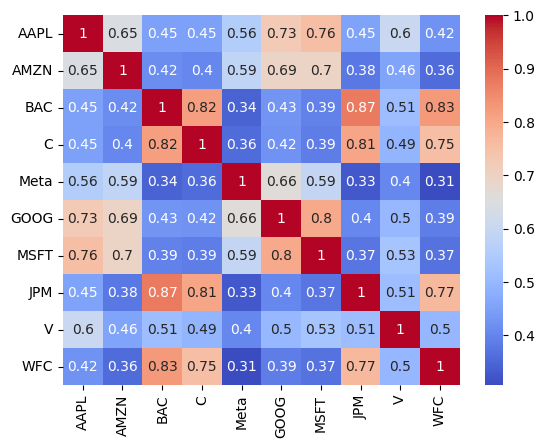

In [149]:
corr = returns_pct.corr() # calculate the correlations between the returns of each pair of stocks
corr # display the correlation matrix
sns.heatmap(corr,annot=True,cmap="coolwarm")

In [150]:
df = pd.DataFrame(corr)

# get the column names
titles = df.columns.tolist()


In [151]:
def truncate(f): # define a function that "rounds" a number to 0 if it is lower than 0.92, and to 1 if it is higher (or equal).
    if (abs(f) < 0.6):
        return 0.
    else:
        return 1
    
# we already know that every stock is perfectly correlated with itself, so the ones on the diagonal are not really useful information. Let's get rid of them.
adj = corr.applymap(truncate) - np.identity(10)
adj

,AAPL,AMZN,BAC,C,Meta,GOOG,MSFT,JPM,V,WFC
AAPL,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
AMZN,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
BAC,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
C,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
Meta,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
GOOG,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
MSFT,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
JPM,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
V,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WFC,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [152]:
stocknet = nx.from_numpy_array(adj.to_numpy()) # initialize a new graph from our adjacency matrix
istocknet=stocknet
istock_layout = nx.spring_layout(istocknet,seed=10)
stocknet = nx.relabel_nodes(stocknet, dict(enumerate(adj.columns))) # keep the stock tickers as the names of the nodes (instead of integers)
stock_layout = nx.spring_layout(stocknet,seed=10) # fix our layout
#nx.draw(stocknet,stock_layout) # plot the graph, without any labels (for now)

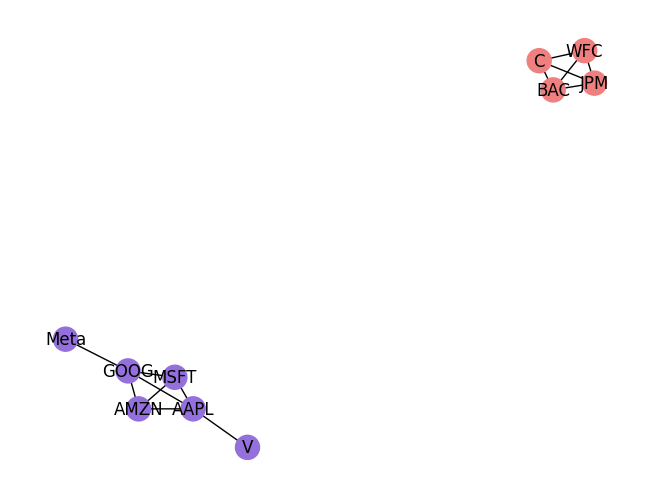

In [153]:
L = nx.laplacian_matrix(stocknet).todense()
(u,v) = np.linalg.eig(L)
u_sorted = np.sort(u)
v_sorted = v[:, u.argsort()]
colors = [ "lightcoral" for i in range(0,10) ]
for i in range(0,10):
    if (v_sorted[i,1] < 0):
        colors[i] = "mediumpurple"
        
nx.draw(stocknet,stock_layout,node_color=colors,with_labels=True)

In [154]:
eigen_cent = nx.eigenvector_centrality(istocknet)
eigen_colors = [eigen_cent[i] for i in range(0,10)]
nx.draw(istocknet,istock_layout,node_color=eigen_colors,with_labels=True)
#nx.draw(stocknet,stock_layout)

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

In [155]:
print(eigen_cent)

{0: 0.46227167164790295, 1: 0.43968327670534785, 2: 9.32424529620248e-06, 3: 9.32424529620248e-06, 4: 0.43968327670534785, 5: 0.43968327670534785, 6: 0.43968327670534785, 7: 9.32424529620248e-06, 8: 0.11410243637487, 9: 9.32424529620248e-06}


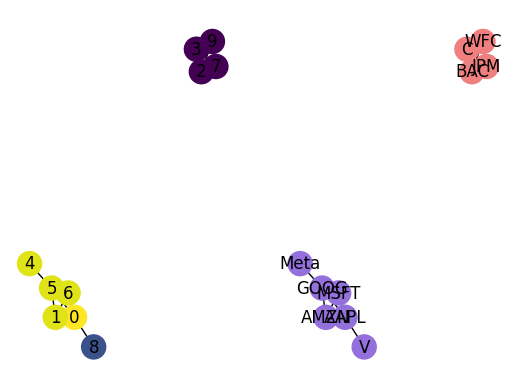

In [156]:
# Create two example graphs
G1 = nx.complete_graph(5)
G2 = nx.cycle_graph(6)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2)

# Draw the graphs in the subplots
nx.draw(istocknet,istock_layout,node_color=eigen_colors,with_labels=True,ax=ax1)
nx.draw(stocknet,stock_layout,node_color=colors,with_labels=True,ax=ax2)

plt.show()

In [157]:
#df = pd.DataFrame(eigen_cent)
print(eigen_cent)
#stocknet = nx.relabel_nodes(stocknet, dict(enumerate(adj.columns)))

{0: 0.46227167164790295, 1: 0.43968327670534785, 2: 9.32424529620248e-06, 3: 9.32424529620248e-06, 4: 0.43968327670534785, 5: 0.43968327670534785, 6: 0.43968327670534785, 7: 9.32424529620248e-06, 8: 0.11410243637487, 9: 9.32424529620248e-06}


In [158]:

df = pd.DataFrame(eigen_cent,index=[0])
dfT= pd.DataFrame(titles)
# print the resulting DataFrame
mat1=df.T
mat2=dfT

joined_mat = pd.concat([mat1, mat2], axis=1)
df=joined_mat
# print the resulting joined matrix
joined_mat.head()
df.columns = ['centrality', 'stock']
df = df.iloc[:, [1, 0]]
df = df.sort_values('centrality',ascending=False)
df=df.reset_index(drop=True)
centralitydf=df

print(centralitydf)

  stock  centrality
0  AAPL    0.462272
1  AMZN    0.439683
2  Meta    0.439683
3  GOOG    0.439683
4  MSFT    0.439683
5     V    0.114102
6   BAC    0.000009
7     C    0.000009
8   JPM    0.000009
9   WFC    0.000009


In [122]:
decay=1
decay_coeff=1/2
def buy_algo (centralitydf,decay,decay_coeff):
    for x in range(0,10)
        buy.df[x]*decay
        decay=decay*decay_coeff
        
def decay_optimizer():
    df=[]
    for x in np.linspace(0, 1, 10)
        df=df.append(buy_algo(cetranlitydf,decay,decay_coeff=x))
        #make code that extracts decay_coeff
        optimal=max(df)
    return optimal,  

    

SyntaxError: expected ':' (2741352801.py, line 4)

In [51]:
from scipy.optimize import minimize_scalar

# Define the function to be optimized
def my_func(x):
    return x**2 - 4*x + 3

# Set the range over which to optimize the function
x_range = (-10, 10)

# Use the minimize_scalar function to find the minimum value of the function within the given range
result = minimize_scalar(my_func, bounds=x_range)

# Print the minimum value and the value of x at which it occurs
print("Minimum value:", result.fun)
print("Optimal x value:", result.x)

Minimum value: -1.0
Optimal x value: 2.0
